# PROGRAMACIÓN PARA CIENCIA DE LOS DATOS -- CURSO 2023-2024
## Tema 4 - Procesamiento de streams
## Boletín de prácticas
### 0. Introduccion
En este boletín vamos a practicar los tres tipos de streams vistos en a clase de teoría,
* El módulo `io`
* El módulo `asyncio`
* `Apache Kafka`

Al final del boletín encontraréis unos ejercicios a realizar de forma individual de cara a repasar los conceptos vistos en la sesión de prácticas.

### 1. El módulo `io`

#### 1.1 Operaciones básicas

Al igual que lo que hacemos con las variables, los datos se pueden guardar como bytes en un buffer en memoria cuando utilizamos las operaciones `BytesIO` del módulo `io`.

In [1]:
import io
import time

stream_str = io.BytesIO(b"Esto es un ejemplo muy sencillo de BytesIO")
print(stream_str.getvalue())

b'Esto es un ejemplo muy sencillo de BytesIO'


Si queremos codificar la salida del stream a un formato de concreto podemos usar el método `decode` especificando el formato de codificación del texto.

In [2]:
print(stream_str.getvalue().decode('utf-8'))

Esto es un ejemplo muy sencillo de BytesIO


Vamos ahora a usar un stream de tipo `StringIO`. Vemos que podemos usar la función `print` especificando el parámetro `file` para escribir sobre un fichero `in-memory`.

In [3]:
data = io.StringIO()
data.write('Inicio del stream StringIO: ')
print('Python.', file=data)

print(data.getvalue())

data.close()

Inicio del stream StringIO: Python.



Vamos a crear ahora un stream binario a un fichero (`test.dat`) y vamos a realizar una escritura sobre el mismo.

In [4]:
begin = time.time()
with open("test.dat", "wb") as f:
  for i in range(0,50000):
    f.write(b"Hola Mundo")
end= time.time()
segundos = end - begin
print("Escritura fichero:",segundos)

Escritura fichero: 0.012300252914428711


Al terminar de ejecutar la celda de arriba, vemos que en nuestro directorio de archivos se ha creado un fichero con el nombre especificado.

Ahora podemos hacer lo mismo pero usando un stream en memoria en vez de uno directamente a un fichero.

In [5]:
begin = time.time()
with io.BytesIO() as f:
  for i in range(0, 50000):
    f.write(b"Hola Mundo")
end = time.time()

segundos = end - begin
print(f"Escritura ficheo: {segundos} segundos")

Escritura ficheo: 0.010179519653320312 segundos


En ambos casos estamos escribiendo sobre un stream binario, salvo que uno va a parar a un fichero `test.dat` y el otro está alojado en la memoria RAM de la máquina.

#### 1.2 Eficiencia
¿Cuál es entonces la diferencia? Vamos comprobar la eficiencia de usar streams `BytesIO` respecto a usar un stream a fichero (disco).

In [6]:
begin = time.time()
buffer = b""
for i in range(0,50000):
  buffer += b"Hola Mundo"
end = time.time()
segundos = end-begin
print("Concatenacion:",segundos)

Concatenacion: 0.514085054397583


In [7]:
begin = time.time()
buffer = io.BytesIO()
for i in range(0,50000):
  buffer.write(b"Hola Mundo")
end= time.time()
segundos = end-begin
buffer.close()
print("BytesIO:",segundos)


BytesIO: 0.012789487838745117


Como vemos el performance es sensiblemente superior si usamos `BytesIO` que la concatenación directa.

Esto, por ejemplo, permitiría otra forma de escritura a ficheros

In [8]:
begin = time.time()
buffer = io.BytesIO()
for i in range(0,50000):
  buffer.write(b"Hola Mundo")

with open("test_bufferio.dat", "wb") as f:
  f.write(buffer.getvalue())
end= time.time()
segundos = end-begin
print("Escritura fichero con BytesIO:",segundos)

Escritura fichero con BytesIO: 0.013362884521484375


#### 1.3 Manipulación streams de fuentes de datos remotas

Vamos a ver cómo podriamos usar los streams `BytesIO` para poder procesar una imagen en lugar de almacenarla en un fichero.

En primer lugar vamos a descargarnos una imagen con el escudo de la UPCT.

In [9]:
from PIL import Image
import requests
import io

response = requests.get("https://www.upct.es/contenido/universidad/galeria/identidad-2021/logos/logos-escuelas-upct-eut/Caminos_upct_eut_1.png")

Creamos un stream `BytesIO` a partir de los datos de la imagen descargada



In [10]:
image_stream = io.BytesIO(response.content)

Abrimos la imagen utilizando la librería PIL (`Python Imaging Library`)

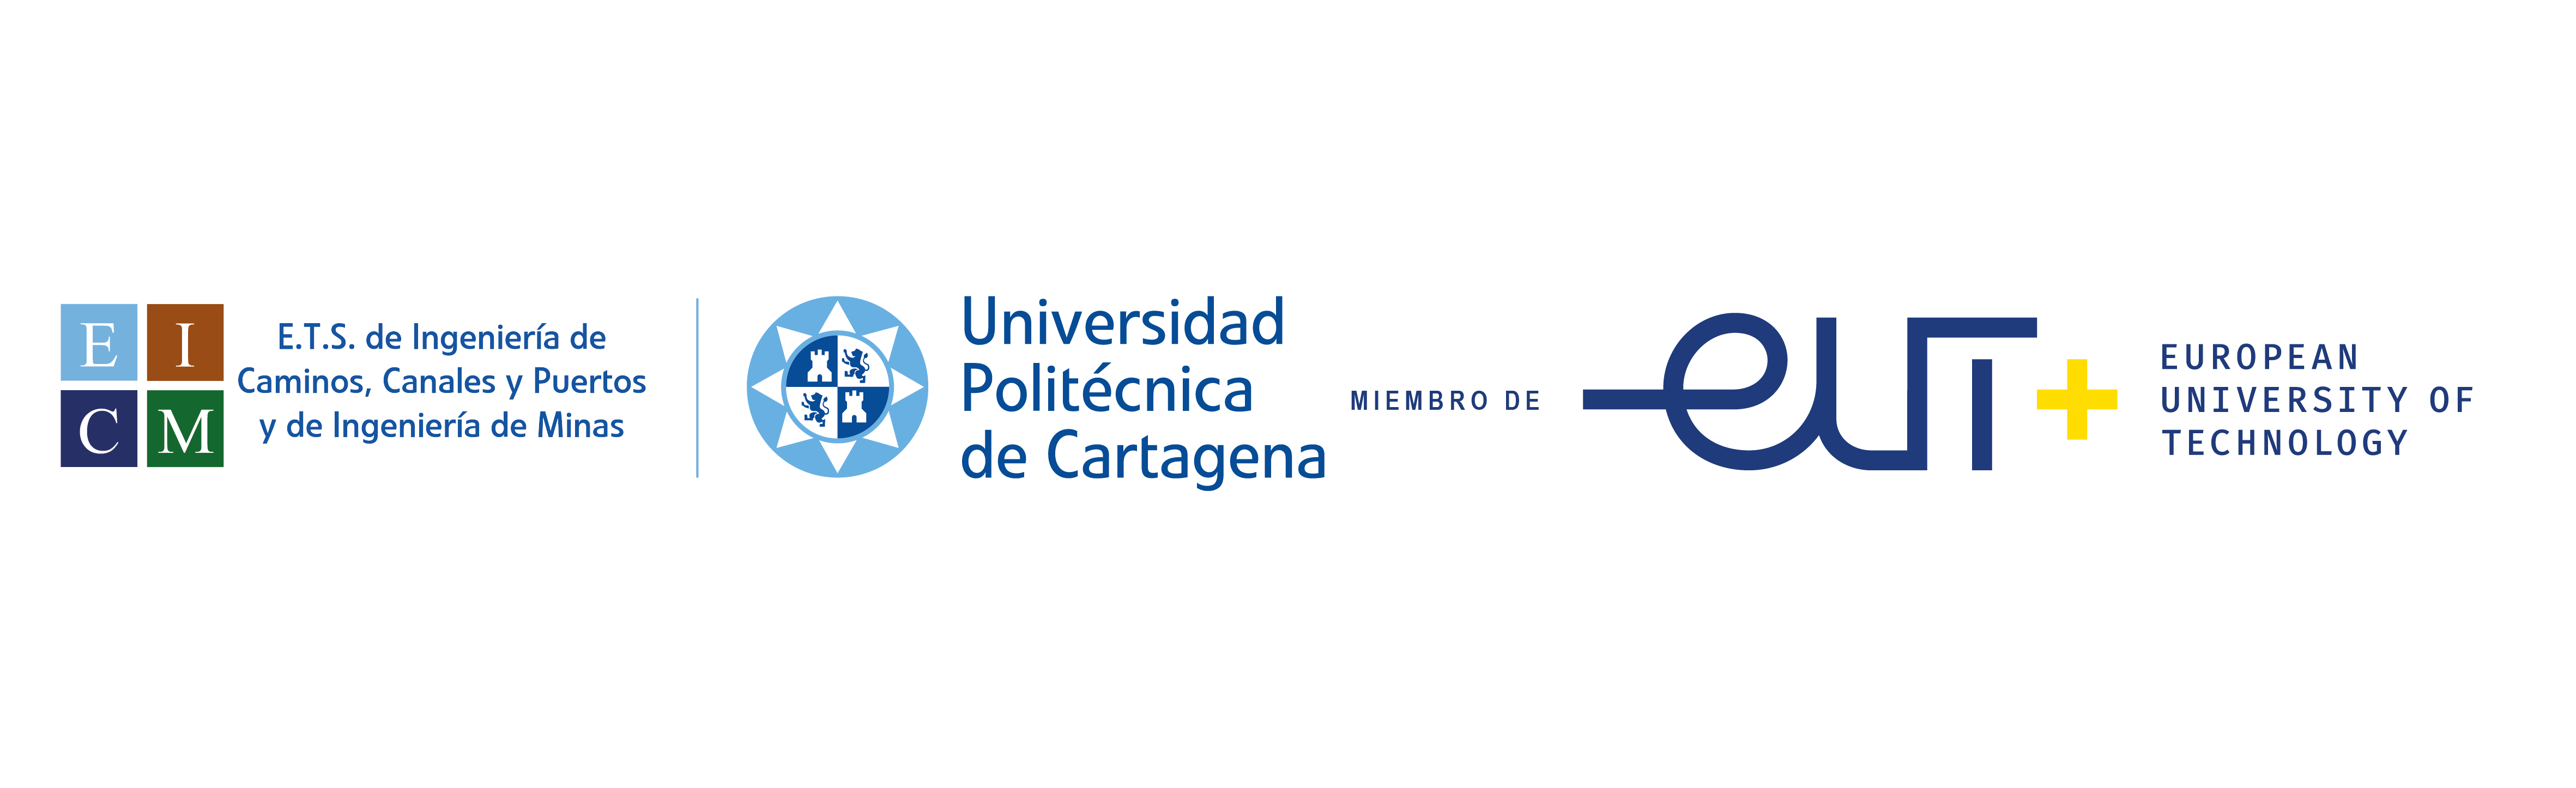

In [11]:
image = Image.open(image_stream)
image

Rotamos la imagen 90 grados en sentido antihorario

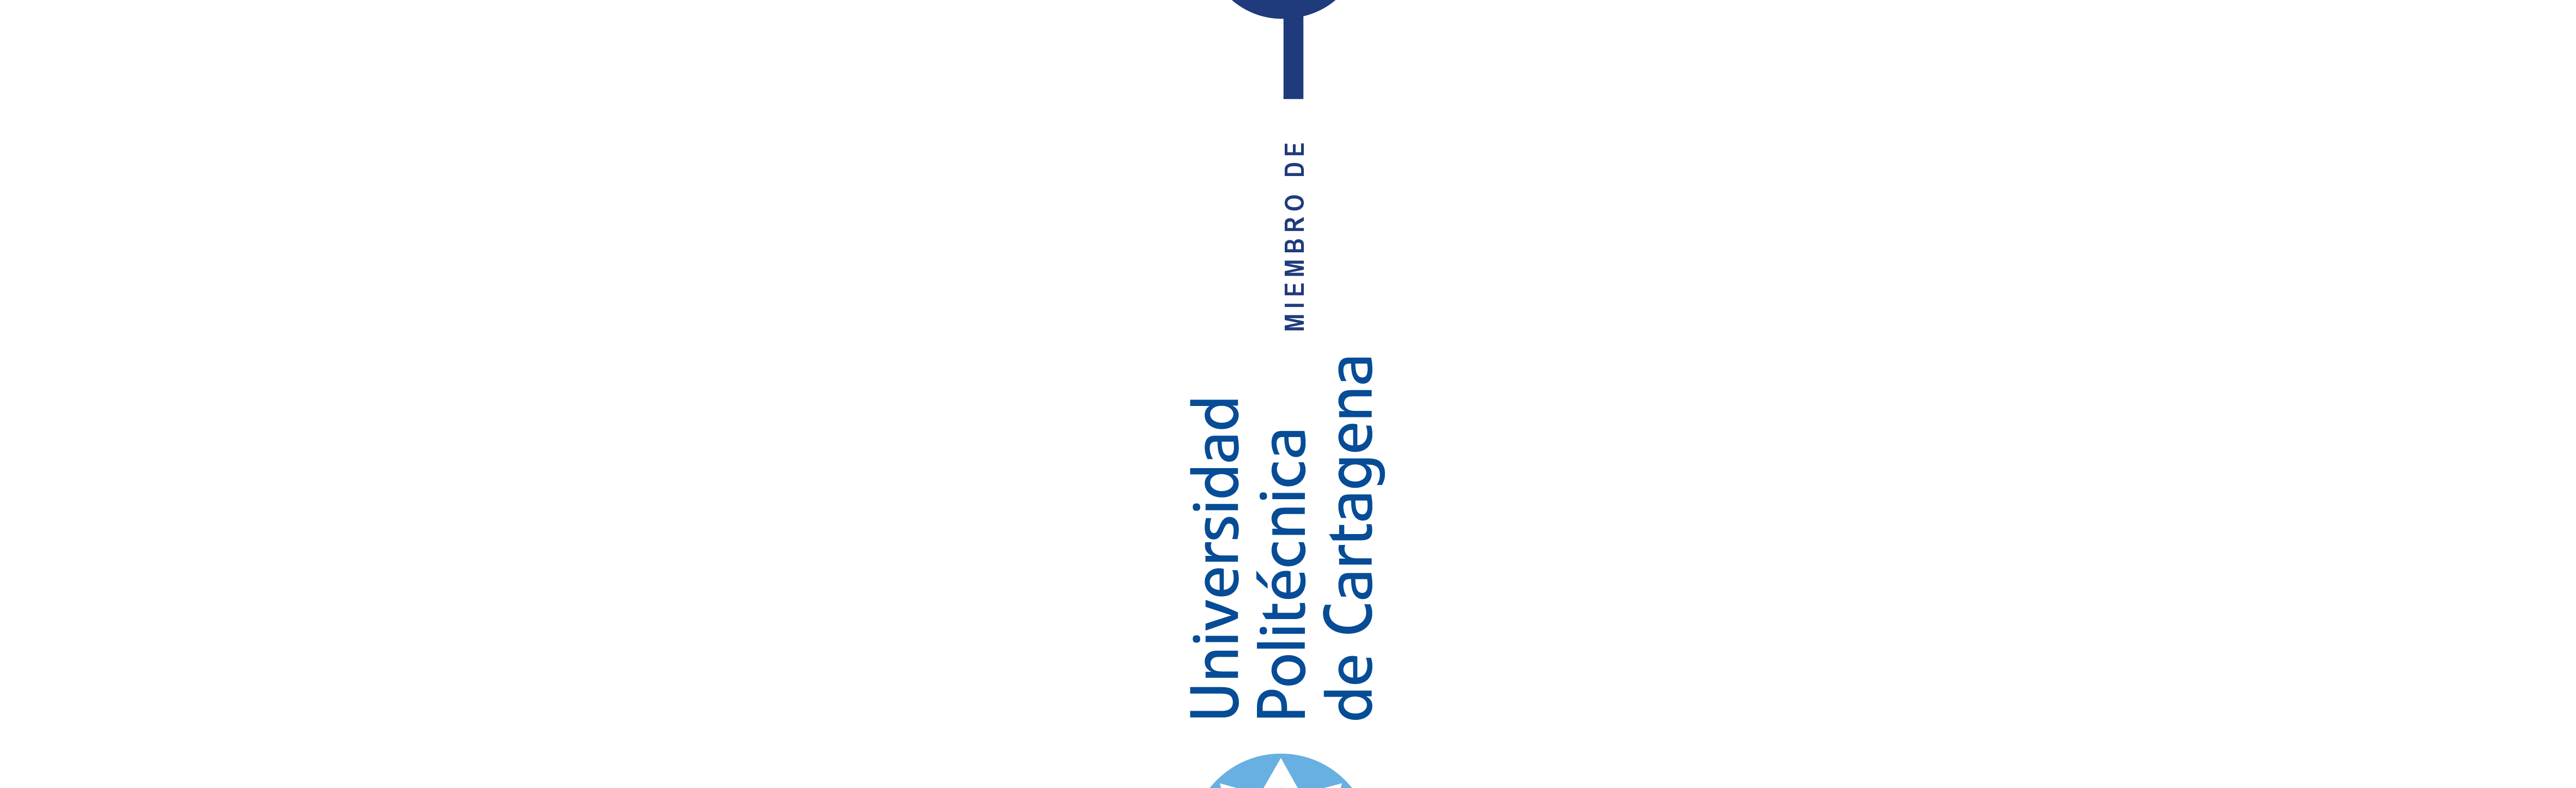

In [12]:
rotated_image = image.rotate(90)
rotated_image

Creamos un nuevo stream `BytesIO` para guardar la imagen rotada

In [13]:
rotated_image_stream = io.BytesIO()

Guardamos la imagen rotada en formato `png` en el nuevo stream `BytesIO`

In [14]:
rotated_image.save(rotated_image_stream, format='PNG')

Guardamos también la imagen rotada en un archivo en disco (solo para comparación)

In [15]:
rotated_image.save("rotated_image.png", format='PNG')

Obtenemos los datos de la imagen rotada como bytes

In [16]:
rotated_image_data = rotated_image_stream.getvalue()

Por último, comparamos el tamaño de los datos de la imagen en disco con los datos en memoria

In [17]:
import os
rotated_image_file_stats= os.stat("rotated_image.png")
print("Tamaño de la imagen rotada en disco:", rotated_image_file_stats.st_size, "bytes")
print("Tamaño de la imagen rotada en memoria:", len(rotated_image_data), "bytes")

Tamaño de la imagen rotada en disco: 66566 bytes
Tamaño de la imagen rotada en memoria: 66566 bytes


#### 1.4 Manejo de punteros

En los streams también podemos controlar los punteros que indican qué datos leer de un stream.

In [18]:
initial_text = "Esto es un ejemplo de texto para usar con StringIO en Python."

Creamos un stream `StringIO` a partir del texto inicial

In [19]:
text_stream = io.StringIO(initial_text)

Leemos los primeros 20 caracteres del stream

In [20]:
parte1 = text_stream.read(40)
print("Primera parte del contenido:", parte1)

Primera parte del contenido: Esto es un ejemplo de texto para usar co


Obtenemos la posición actual del puntero

In [21]:
posicion_actual = text_stream.tell()
print("Posición actual del puntero:", posicion_actual)

Posición actual del puntero: 40


Movemos el puntero al inicio del stream

In [22]:
text_stream.seek(0)

0

Leemos los siguientes 15 caracteres del stream desde el principio

In [23]:
parte2 = text_stream.read(15)
print("Segunda parte del contenido:", parte2)

Segunda parte del contenido: Esto es un ejem


Obtenemos la nueva posición del puntero

In [24]:
nueva_posicion = text_stream.tell()
print("Nueva posición del puntero:", nueva_posicion)

Nueva posición del puntero: 15


### 2. El módulo `asyncIO`

A fin de practicar con las corutinas en primer lugar vamos a crear una muy sencilla que simplemente *duerme* durante 1 segundo y a continuación se imprime un mensaje.

#### 2.1 Creación de corutinas

In [25]:
import asyncio

async def mi_corutina():
    # Código asincrónico
    await asyncio.sleep(5)
    return "¡Hola, soy una corutina!"

En un entorno Python *tradicional* la forma de invocar a dicha corutina sería mediante el siguiente código.

In [26]:
# resultado = asyncio.run(mi_corutina())
# print(resultado)

¿Qué ha fallado? Pues que en un notebook el código ya se ejecuta en un bucle de eventos (`event loop`) al estar en un Jupyer Notebook. Por tanto, la forma correcta de invocar a dicha corutina es mediante la siguiente instrucción.

In [27]:
await mi_corutina()

'¡Hola, soy una corutina!'

Por otro lado, las corutinas pueden esperar otras corutinas usando
el comando `await`

Vamos a crear una segunda corutina que espera a obtener el resulado de `mi_corutina` afin de mostrar un mensaje por pantalla.



In [28]:
async def corutina_principal():
    resultado = await mi_corutina()
    print("He recibido::", resultado)

await corutina_principal()

He recibido:: ¡Hola, soy una corutina!


También podemos ejecutar

In [29]:
async def corutina_1():
    await asyncio.sleep(1)
    print("Corutina 1 terminada")

async def corutina_2():
    await asyncio.sleep(2)
    print("Corutina 2 terminada")

async def correr_corutinas():
    await asyncio.gather(corutina_1(), corutina_2(), mi_corutina())

await correr_corutinas()

Corutina 1 terminada
Corutina 2 terminada


#### 2.2 Ejemplo avanzado

Vamos a ver un ejemplo de uso de corutinas para procesar un texto muy largo de forma paralela.

In [30]:
async def procesar_texto(texto):
    print("Iniciando procesamiento de texto")
    # Simulamos un procesamiento intensivo del texto
    await asyncio.sleep(3)
    texto_procesado = texto.upper()
    print("Procesamiento de texto finalizado")
    return texto_procesado

async def procesar_texto_en_paralelo(texto):
    # Creamos varias corutinas para procesar el texto simultáneamente
    corutina_1 = procesar_texto(texto[:10])
    corutina_2 = procesar_texto(texto[10:25])
    corutina_3 = procesar_texto(texto[25:])

    # Ejecutamos las corutinas simultáneamente
    resultados = await asyncio.gather(corutina_1, corutina_2, corutina_3)

    return resultados

async def main():
    # Supongamos que tenemos un texto muy largo
    texto_largo = "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Fusce pretium est a magna vestibulum, eget consequat orci sollicitudin."

    # Procesamos el texto utilizando múltiples corutinas en paralelo
    resultados = await procesar_texto_en_paralelo(texto_largo)

    # Imprimimos los resultados
    for i, resultado in enumerate(resultados, start=1):
        print(f"Texto procesado {i}:", resultado[:50], "...")
        print(f"Longitud del texto procesado {i}:", len(resultado))

# Recuerda que si quisieras ejecutar este código en un entorno fuera del un Jupyter notebook deberias ejecutarl
#asyncio.run(main())

await main()


Iniciando procesamiento de texto
Iniciando procesamiento de texto
Iniciando procesamiento de texto
Procesamiento de texto finalizado
Procesamiento de texto finalizado
Procesamiento de texto finalizado
Texto procesado 1: LOREM IPSU ...
Longitud del texto procesado 1: 10
Texto procesado 2: M DOLOR SIT AME ...
Longitud del texto procesado 2: 15
Texto procesado 3: T, CONSECTETUR ADIPISCING ELIT. FUSCE PRETIUM EST  ...
Longitud del texto procesado 3: 103


### 3. Apache Kafka



#### 3.1 Instalación de los paquetes `kafka`

En primer lugar vamos a instalar la librería `kafka-python` que es la que nos va a permitir usar el framework de kafka a través de Python.

In [31]:
!pip install kafka-python

#### 3.2 Descargamos e instalamos las instancias Kafka and Zookeeper instances

En este boletín instalaremos y ejecutaremos las siguientes instancias:

- Kafka (Brokers: 127.0.0.1:9092)
- Zookeeper (Node: 127.0.0.1:2181)


In [32]:
!curl -sSOL https://dlcdn.apache.org/kafka/3.6.2/kafka_2.13-3.6.2.tgz
!tar -xzf kafka_2.13-3.6.2.tgz

In [33]:
!./kafka_2.13-3.6.2/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.6.2/config/zookeeper.properties
!./kafka_2.13-3.6.2/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.6.2/config/server.properties
!echo "Esperamos 10 segundos hasta que los servicios kafka y zookeeper estén activos y funcionando"
!sleep 10

Esperamos 10 segundos hasta que los servicios kafka y zookeeper estén activos y funcionando


Una vez que se han iniciado las instancias como procesos *demonio* en el servidor, ejecutarmos el comando `grep` para obtener el listado de procesos en el servidor y ver que efectivamente tenemos los servicios zookeeper y kafka activados.

In [34]:
!ps -ef | grep kafka

root        8268    7172  0 10:17 ?        00:00:00 /bin/bash -c ps -ef | grep kafka
root        8270    8268  0 10:17 ?        00:00:00 /bin/bash -c ps -ef | grep kafka


Creamos el tópico kafka con el que vamos a trabajar, en este caso lo vamos a llamar `netflix`

In [35]:
!./kafka_2.13-3.6.2/bin/kafka-topics.sh --create --topic netflix --bootstrap-server localhost:9092

Error while executing topic command : Topic 'netflix' already exists.
[2024-05-14 10:17:47,378] ERROR org.apache.kafka.common.errors.TopicExistsException: Topic 'netflix' already exists.
 (kafka.admin.TopicCommand$)


Obtenemos una descripción del tópico recién creado.

In [36]:
!./kafka_2.13-3.6.2/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092  --topic netflix

Topic: netflix	TopicId: aSkxrwT1RmS_rxW_R5_fSg	PartitionCount: 1	ReplicationFactor: 1	Configs: 
	Topic: netflix	Partition: 0	Leader: 0	Replicas: 0	Isr: 0


#### 3.3 Productor

Vamos ahora a crear el productor para nuestro escenario. Dicho productor va a simular la evolución en tiempo real del precio de las acciones de *Netflix* en la bolsa.

In [37]:
nombre_topico='netflix'

El código de dicho productor se encuentra en el fichero `producer.py` que puedes descargarte del aula virtual junto con el fichero `NFLX.csv`

Sube ambos ficheros a *Google Collab* en el directorio raiz.

Vamos a visualizar su contenido, en donde podemos ver que dicho productor va leyendo línea por línea el fichero `NFLX.csv` con el valor de las acciones y las va lanzando al broker Kafka asociado al tópico `netflix`.

In [38]:
!cat producer.py

cat: producer.py: No such file or directory


Ahora vamos a ejecutar dicho productor en segundo plano para simular el envio asíncrono y en tiempo real de los valores bursátiles de *Netflix*.

Para ello, hacemos uso del comando `nohup` de Linux.

In [39]:
!nohup python -m producer NFLX.csv netflix 5 &

nohup: appending output to 'nohup.out'


Podemos visualizar por consola los mensajes que dicho productor ya ha enviado al broker asociados al tópico `netflix` usando el script `kafka-console-consumer.sh`

In [40]:
!./kafka_2.13-3.6.1/bin/kafka-console-consumer.sh --topic netflix --from-beginning --bootstrap-server localhost:9092

/bin/bash: line 1: ./kafka_2.13-3.6.1/bin/kafka-console-consumer.sh: No such file or directory


#### 3.4 Consumidor

El consumidor vamos a implementarlo como una clase muy sencilla que usa la clase `KafkaConsumer`para definir un cosumidor sobre el tópico `netflix` y en el que su método  `receive_message` se encarga de ir imprimiendo por pantalla cada nuevo mensaje leido y almacenandolo en una lista en su atributo `data`.

In [41]:
from kafka import KafkaConsumer
import json


class Consumer:
    def __init__(self, topic):
        self._consumer = KafkaConsumer(topic,
                                       bootstrap_servers='localhost:9092',
                                       value_deserializer=lambda x: json.loads(x.decode('utf-8')),
                                       group_id='nflx')

        self.data = []

    @property
    def consumer(self):
        return self._consumer

    @consumer.setter
    def consumer(self, value):
        if isinstance(value, KafkaConsumer):
            self._consumer = value

    def iniciar_consumicion(self):
        self.receive_message()

    def receive_message(self):
        message_count = 0
        for message in self._consumer:
            message = message.value
            print(f'Message {message_count}: {message}')
            self.data.append(message)
            message_count += 1


Ya solo nos queda instanciar el consumidor e iniciar su lectura de los eventos enviados por el productor invocando al método `iniciar_consumición`.

In [42]:
''' consumer = Consumer(nombre_topico)
consumer.iniciar_consumicion() '''

KeyboardInterrupt: 

### 4. Ejercicios

#### Ejercicio 1 - Modulo `io`

Usando un stream `ByteIO` que tome como entrada la cadena `Tengan cuidado, ese mancebo es un gorila frenetico`, realiza tres lecturas, en el orden indicado abajo, sobre dicho stream usando el comando `.read`

- Una primera lectura que solo obtenga la parte *Tengan cuidado,*
- Una segunda lectura que solo obtenga la parte *ese mancebo es un gorila frenetico.*
- Una tercera lectura que obtenga la frase entera (PISTA: recuerda lo que hacía el comando `.seek`).

In [60]:
import io

cadena_de_texto = io.BytesIO(b"Tengan cuidado, ese mancebo es un gorilla frenetico")
print(cadena_de_texto.read(15))
print(cadena_de_texto.read(40))
print(cadena_de_texto.getvalue().decode('utf-8'))

b'Tengan cuidado,'
b' ese mancebo es un gorilla frenetico'
Tengan cuidado, ese mancebo es un gorilla frenetico


#### Ejercicio 2 - Módulo `asyncIO`



Definir la corrutina que reciba como argumentos un número inicial, un número final y un retardo, de forma que imprima todos los números desde el numero inicial al final y entre casa impresión se espere los segundos indicadaos por el retardo.

Ejecutar tres instancias de dicha corutina, cada una con un rango de valores diferente:
- Una corutina que imprima los número del 10 al 20 con un retardo de 1 segundo.
- Otra corutina que imprima los números del 20 al 30 con un retardo de 0.5 segundos y
- otra corutina que imprima los números del 30 al 40 con un retardo de 2 segundos.




In [67]:
import asyncio

async def mi_corutina(num_inicial: int, num_final: int, retardo: float):
  for i in range(num_inicial, num_final+1):
    await asyncio.sleep(retardo)
    print(i)

# await mi_corutina(10, 20, 1)
# await mi_corutina(20, 30, 0.5)
# await mi_corutina(30, 40, 2)

30
31
32
33
34
35
36
37
38
39
40


#### Ejercicio 3 - Apache Kafka

Modifica el código del consumidor para almacenar el máximo valor de la cotización recibida hasta el momento. Para ello, se deberá consultar el campo `open_price` de los eventos recibidos.

**IMPORTANTE: Para poder probar este ejercicio es necesario reiniciar el entorno de ejecución en *Google Collab*. Para ello, pulsa sobre el menú `Entorno de ejecución -> Reiniciar sesión`**

Una vez reiniciado el entorno, ejecutamos de nuevo las siguientes instrucciones para iniciar Kafka y el productor que ya vimos antes.

In [68]:
#Instalamos la librería de kafka-python
!pip install kafka-python
#Descargamos y arrancamos Apache Kafka
!curl -sSOL https://dlcdn.apache.org/kafka/3.6.1/kafka_2.13-3.6.1.tgz
!tar -xzf kafka_2.13-3.6.1.tgz
!./kafka_2.13-3.6.1/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.6.1/config/zookeeper.properties
!./kafka_2.13-3.6.1/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.6.1/config/server.properties
!echo "Esperamos 10 segundos hasta que los servicios kafka y zookeeper están activos y funcionando"
!sleep 10
!./kafka_2.13-3.6.1/bin/kafka-topics.sh --create --topic netflix --bootstrap-server localhost:9092
#Iniciamos el productor
!nohup python -m producer NFLX.csv netflix 5 &


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now
/bin/bash: line 1: ./kafka_2.13-3.6.1/bin/zookeeper-server-start.sh: No such file or directory
/bin/bash: line 1: ./kafka_2.13-3.6.1/bin/kafka-server-start.sh: No such file or directory
Esperamos 10 segundos hasta que los servicios kafka y zookeeper están activos y funcionando
/bin/bash: line 1: ./kafka_2.13-3.6.1/bin/kafka-topics.sh: No such file or directory
nohup: appending output to 'nohup.out'


A continuacion ya puedes definir tu consumidor. Inserta el código dentro de la función `receive_message`.

In [69]:
from kafka import KafkaConsumer
import json


class Consumer:
    def __init__(self, topic):
        self._consumer = KafkaConsumer(topic,
                                       bootstrap_servers='localhost:9092',
                                       value_deserializer=lambda x: json.loads(x.decode('utf-8')),
                                       group_id='nflx')

        self._max_value= -1

    @property
    def consumer(self):
        return self._consumer

    @consumer.setter
    def consumer(self, value):
        if isinstance(value, KafkaConsumer):
            self._consumer = value

    def iniciar_consumicion(self):
        self.receive_message()

    def receive_message(self):
      #Inserta aquí la funcionalidad solicitada en el ejercicio
      pass

In [70]:
consumer = Consumer('netflix')
consumer.iniciar_consumicion()

## Referencias

[Super Fast Python. Python Asyncio: The Complete Guide. 2023](https://superfastpython.com/python-asyncio/)

¡Eso es todo amigos!